Note: it is recommended you download this notebook to your own PC if you want to train the model, as Kaggle's servers will be slow and have a timeout. 

### Load data and do preprocessing 
First we load our data into Pandas dataframes and convert them to NumPy arrays using *.values*. We further convert the datatype from *float64* to *float32* for speed. 

Since the training examples are 1D vectors, and we wish to do convolutions on the 2D images, we reshape the input data from (n_train x 784) to (n_train x 28 x 28). We also normalize the data to the interval [0,1], while this is not really necessary here as all the pixel values already lie in the same range [0, 255], it is a good procedure to follow in general. 

We used *to_categorical* to transform the target data (which lies in the set [0,1,2,3,4,5,6,7,8,9]) to one hot vectors. 

In [1]:
import pandas as pd
import numpy as np
from keras.utils.np_utils import to_categorical
from keras import backend as K

K.set_image_dim_ordering('th') #input shape: (channels, height, width)

train_df = pd.read_csv("../input/train.csv")
valid_df = pd.read_csv("../input/test.csv")

x_train = train_df.drop(['label'], axis=1).values.astype('float32')
Y_train = train_df['label'].values
x_valid = valid_df.values.astype('float32')

img_width, img_height = 28, 28

n_train = x_train.shape[0]
n_valid = x_valid.shape[0]

n_classes = 10 

x_train = x_train.reshape(n_train,1,img_width,img_height)
x_valid = x_valid.reshape(n_valid,1,img_width,img_height)

x_train = x_train/255 #normalize from [0,255] to [0,1]
x_valid = x_valid/255 

y_train = to_categorical(Y_train)

Using TensorFlow backend.


### View an image to make sure everything is OK
(The images are not color, but *imshow()* applies a colormap by default, and I'm not sure how to disable it)

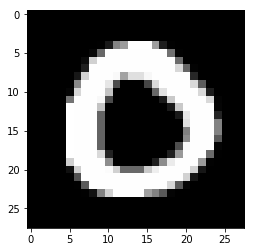

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

imgplot = plt.imshow(x_train[4,0,:,:,],cmap='gray')

### Build Model 

** Handling edges/borders **  
One thing we have to decide is how to deal with the edges. To allow convolution of the data at the edges, one can first 'zero pad' the input array, by adding zeros to the left, right, top, and bottom. ie:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;00000<br>
123&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;01230<br>
456&nbsp;-->&nbsp;04560<br>
789&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;07890<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;00000<br> 


This can be done with the [ZeroPadding2D()](https://keras.io/layers/convolutional/#ZeroPadding2D) function in Keras. One must make sure to zero pad with enough zeros -- one needs *filter_size/2* zeros. 

Alternatively, a simpler solution is to set *border_mode='same'*, which returns a filter map of the same size and automatically appends zeros. 

The other option available in Keras is *border_mode='valid'* which only does convolutions where the filter fits inside the image (also called narrow convolution). With this option set, the filter map has smaller dimensions than the input image. 

**[2D Convolution](https://keras.io/layers/convolutional/#convolution2d)**  
The main operation in the CNN. 


**[Max Pooling](https://keras.io/layers/pooling/#maxpooling2d)**  
Max pooling reduces the size of the filter maps, by applying a *max filter* to non-overlapping subregions. A max pooling layer with pooling_size=2 (ie using 2x2 max filters) will reduce the number total number of parameters in the filter map by a factor of 4.

**[Dropout](https://keras.io/layers/core/#dropout)**  
This is a technique for preventing overfitting. The dropout layer in Keras randomly drops a certain fraction of the neurons (units) with a probability p in each training round. This forces the network to learn redundant representations, and effectively lowers the number of paramters while maintaining a wide degree of flexibility.

**[Flattening](https://keras.io/layers/core/#flaten)**  
Flattening converts the input activations, which are in an array of shape (n_filters, filter_size_x, filter_size_y) into a 1D array. 

**[Dense layer](https://keras.io/layers/core/#dense)**  
This is a fully connected layer of neurons which works on the 1D input and gives a 1D output. 

**[Softmax activation](https://en.wikipedia.org/wiki/Softmax_function#Artificial_neural_networks)**  
Softmax converts the input  

### Hyperparameters for this model

* Number of filters (n_filters) 

* Size of convolution filters (filter_size1, filter_size2)  

* Size of pooling windows (pool_size1, pool_size2)

* Size of the dense layer (n_dense)

### Compilation  
The 'compilation' step is where you specify your loss function in Keras. In this case, we use categorical crossentropy. 

In [3]:
from keras.models import Sequential
from keras.layers.convolutional import *
from keras.layers.core import Dropout, Dense, Flatten, Activation

n_filters = 64
filter_size1 = 3
filter_size2 = 2
pool_size1 = 3
pool_size2 = 1
n_dense = 128

model = Sequential()

model.add(Convolution2D(n_filters, filter_size1, filter_size1, batch_input_shape=(None, 1, img_width, img_height), activation='relu', border_mode='valid'))

model.add(MaxPooling2D(pool_size=(pool_size1, pool_size1)))

model.add(Convolution2D(n_filters, filter_size2, filter_size2, activation='relu', border_mode='valid'))

model.add(MaxPooling2D(pool_size=(pool_size2, pool_size2)))

model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(n_dense))

model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(n_classes))

model.add(Activation('softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Fit the model
see *[fit()](https://keras.io/models/sequential/#fit)* documentation  

In [4]:
batch_size = 128
n_epochs = 1

model.fit(x_train,
          y_train,
          batch_size=batch_size,
          nb_epoch=n_epochs,verbose=2,
          validation_split=.2)

Train on 33600 samples, validate on 8400 samples
Epoch 1/1
335s - loss: 0.4335 - acc: 0.8642 - val_loss: 0.1017 - val_acc: 0.9689


### Run model on validation data and save output
see *[predict_classes()](https://keras.io/models/sequential/#predict_classes)* documentation. 

(By contrast, *[predict()](https://keras.io/models/sequential/#predict)*  would return an array with shape (n_examples, n_classes), where each number represents a probability for the class in question.)


In [5]:
yPred = model.predict_classes(x_valid,batch_size=32,verbose=1)

np.savetxt('mnist_output.csv', np.c_[range(1,len(yPred)+1),yPred], delimiter=',', header = 'ImageId,Label', comments = '', fmt='%d')

28000/28000 [==============================] - 148s   
